In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)

RANDOM_SEED = 1234567

az.style.use("arviz-darkgrid")

In [2]:
UCB_data = '../../data/ucbadmit.csv'

In [3]:
df = pd.read_csv(UCB_data)
df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [4]:
df['applications_by_dept'] = df.groupby('dept')['applications'].transform('sum')

In [5]:
df['fraction_admitted'] = df['admit'] / df['applications']
df['frac_applicants'] = df['applications'] / df['applications_by_dept']
df.round(2)

,dept,applicant.gender,admit,reject,applications,applications_by_dept,fraction_admitted,frac_applicants
1,A,male,512,313,825,933,0.62,0.88
2,A,female,89,19,108,933,0.82,0.12
3,B,male,353,207,560,585,0.63,0.96
4,B,female,17,8,25,585,0.68,0.04
5,C,male,120,205,325,918,0.37,0.35
6,C,female,202,391,593,918,0.34,0.65
7,D,male,138,279,417,792,0.33,0.53
8,D,female,131,244,375,792,0.35,0.47
9,E,male,53,138,191,584,0.28,0.33
10,E,female,94,299,393,584,0.24,0.67


## Model I

We wish to model the probability of admission, given the gender of the applicant. In the first pass, we ignore the department where admissions are being sought. 

The model is as follows:
\begin{align*}
    A_i                    & \sim \text{Binomial} (N_i, p_i) \\
    \text{logit}(p_i)      & \sim \alpha_{\text{gender}[i]}  \\
    \alpha_{\text{male}}   & \sim \text{Normal}(0, 1.5)      \\
    \alpha_{\text{female}} & \sim \text{Normal}(0, 1.5)
\end{align*}

Here $N_i$ is the number of applicants in row $i$ and $\alpha$ is an intercept term that may vary by gender. 

In [6]:
gender_ids, gender = pd.factorize(df['applicant.gender'])

with pm.Model() as m_11_7:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=df['applicant.gender'].nunique())
    gender_id = pm.intX(pm.Data('gender_id', gender_ids))
    p = pm.Deterministic('p', pm.math.invlogit(a[gender_id]))
    
    admit = pm.Binomial('admit', n=df['applications'], p=p, observed=df['admit'])
    
    trace_11_7 = pm.sample(2000, tune=2000, return_inferencedata=False, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [7]:
az.summary(trace_11_7, var_names=['a'], round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.04,-0.28,-0.16,0.0,0.0,6881.64,5693.70,1.0
a[1],-0.83,0.05,-0.91,-0.75,0.0,0.0,6387.99,5202.95,1.0


### Code 11.30

In [8]:
df_11_7 = pm.trace_to_dataframe(trace_11_7)
df_11_7.head()

,a__0,a__1,p__0,p__1,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,-0.264973,-0.918664,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230
1,-0.247984,-0.876756,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851
2,-0.247984,-0.876756,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851
3,-0.192547,-0.936629,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582
4,-0.223712,-0.753179,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


df_11_7['diff_a'] = df_11_7['a__0'] - df_11_7['a__1']
df_11_7['diff_p'] = sigmoid(df_11_7['a__0']) - sigmoid(df_11_7['a__1'])

In [10]:
df_11_7[['diff_a', 'diff_p']].describe(percentiles=[0.055, 0.945]).round(2).T

,count,mean,std,min,5.5%,50%,94.5%,max
diff_a,8000.0,0.61,0.06,0.39,0.51,0.61,0.71,0.84
diff_p,8000.0,0.14,0.01,0.09,0.12,0.14,0.16,0.19


In [11]:
def plot_posteriors(df_data, df_post):
    idx = [2 * y for y in range(0, 6)]

    for i in idx:
        x = i + 1

        y1 = df_data['fraction_admitted'].values[i]
        y2 = df_data['fraction_admitted'].values[i + 1]

        plt.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.5, lw=2)
        plt.text(x + 0.25, (y1 + y2) / 2 + 0.05, df.dept.values[i])


        pos_male_desc = df_post[f'p__{i}'].describe(percentiles=[0.055, 0.945])
        pos_fem_desc = df_post[f'p__{i + 1}'].describe(percentiles=[0.055, 0.945])

        male_mean = pos_male_desc.loc['mean']
        male_lo = pos_male_desc.loc['5.5%']
        male_hi = pos_male_desc.loc['94.5%']

        fem_mean = pos_fem_desc.loc['mean']
        fem_lo = pos_fem_desc.loc['5.5%']
        fem_hi = pos_fem_desc.loc['94.5%']

        plt.plot(x, male_mean, 'ko', fillstyle="none", alpha=0.3)
        plt.plot(x + 1, fem_mean, 'ko', fillstyle="none", alpha=0.3)
        plt.vlines(x=x, ymin=male_lo, ymax=male_hi, linestyle='--', color='k', alpha=0.3)
        plt.vlines(x=x + 1, ymin=fem_lo, ymax=fem_hi, linestyle='--', color='k', alpha=0.3)

    plt.xlabel('case')
    plt.ylabel('admit')

    plt.gca().set_ylim(bottom=0.0, top=1.0)
    plt.xticks(range(1, 13))

    plt.plot();

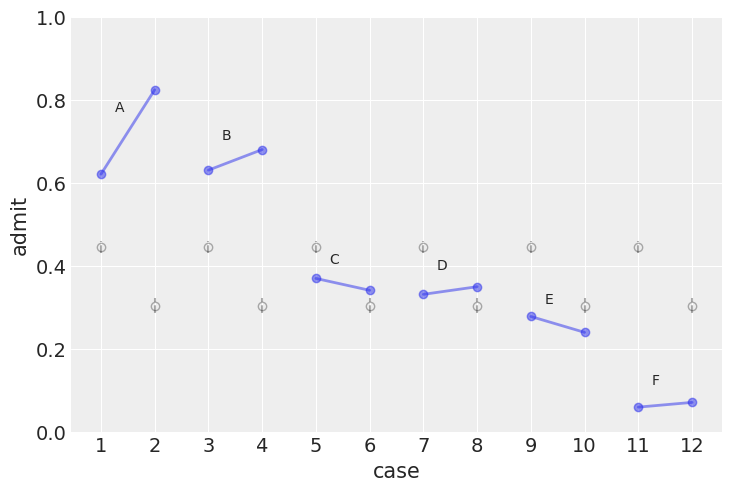

In [12]:
plot_posteriors(df, df_11_7)

In [13]:
df.groupby('applicant.gender')['fraction_admitted'].mean()

applicant.gender
female    0.417269
male      0.381266
Name: fraction_admitted, dtype: float64

In [14]:
df_temp = df.groupby('applicant.gender')[['admit', 'applications']].sum().reset_index()
df_temp

,applicant.gender,admit,applications
0,female,557,1835
1,male,1198,2691


In [15]:
df_temp['prob_admit'] = df_temp['admit'] / df_temp['applications']
df_temp

,applicant.gender,admit,applications,prob_admit
0,female,557,1835,0.303542
1,male,1198,2691,0.445188


In [16]:
mean_male_prob = np.mean(sigmoid(df_11_7['a__0']))
mean_fem_prob = np.mean(sigmoid(df_11_7['a__1']))

In [17]:
mean_male_prob, mean_fem_prob

(0.44522002029043356, 0.3036519689060527)

## Intermediate Conclusion

The model actually does a good job in predicting the overall probability of admission over all departments. As can be seen, the average probability of admission of male and female students obtained from posterior samples actually match the values obtained directly from the data. Since the number of male and female applicants vary by department and the rates of admission vary across departments, one must take the department into account in the model.

## Modified Question

What is the average difference in probability of admission between men and women within departments?

In [18]:
df_diff = df.groupby('dept')['fraction_admitted'].apply(lambda rows: rows.iloc[0] - rows.iloc[1]).reset_index()
df_diff

,dept,fraction_admitted
0,A,-0.203468
1,B,-0.049643
2,C,0.028590
3,D,-0.018398
4,E,0.038301
5,F,-0.011400


In [19]:
df_diff['fraction_admitted'].mean()

-0.03600297173788926

## Model 2

\begin{align*}
    A_i                    & \sim \text{Binomial} (N_i, p_i) \\
    \text{logit}(p_i)      & \sim \alpha_{\text{gender}[i]} + \delta_{\text{dept}[i]} \\
    \alpha_{\text{male}}   & \sim \text{Normal}(0, 1.5)      \\
    \alpha_{\text{female}} & \sim \text{Normal}(0, 1.5)      \\
    \delta_{k}             & \sim \text{Normal}(0, 1.5) \text{ for each dept } k
\end{align*}


### Code 11.32

In [20]:
gender_ids, gender = pd.factorize(df['applicant.gender'])
dept_ids, dept = pd.factorize(df['dept'])

with pm.Model() as m_11_8:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=df['applicant.gender'].nunique())
    delta = pm.Normal('delta', mu=0, sigma=1.5, shape=df['dept'].nunique())
    
    gender_id = pm.intX(pm.Data('gender_id', gender_ids))
    dept_id = pm.intX(pm.Data('dept_id', dept_ids))
    
    p = pm.Deterministic('p', pm.math.invlogit(a[gender_id] + delta[dept_id]))
    admit = pm.Binomial('admit', n=df['applications'], p=p, observed=df['admit'])
    
    trace_11_8 = pm.sample(2000, tune=2000, return_inferencedata=False, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
az.summary(trace_11_8, var_names=['a', 'delta'], round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.53,0.54,-1.45,0.28,0.02,0.01,857.39,937.60,1.0
a[1],-0.43,0.55,-1.34,0.41,0.02,0.01,859.84,973.54,1.0
delta[0],1.11,0.55,0.29,2.04,0.02,0.01,863.33,934.28,1.0
delta[1],1.06,0.55,0.19,1.95,0.02,0.01,865.70,1012.80,1.0
delta[2],-0.15,0.55,-1.04,0.72,0.02,0.01,859.34,956.81,1.0
delta[3],-0.18,0.55,-0.97,0.78,0.02,0.01,866.13,998.34,1.0
delta[4],-0.63,0.55,-1.49,0.28,0.02,0.01,869.81,1033.67,1.0
delta[5],-2.18,0.56,-3.09,-1.29,0.02,0.01,902.58,1137.07,1.0


### Code 11.33

In [22]:
df_11_8 = pm.trace_to_dataframe(trace_11_8)
df_11_8.head()

,a__0,a__1,delta__0,delta__1,delta__2,delta__3,delta__4,delta__5,p__0,p__1,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,-0.085304,0.050902,0.637456,0.572866,-0.675666,-0.823777,-1.186241,-2.808607,0.634635,0.665602,0.619532,0.651075,0.318436,0.348699,0.287188,0.315857,0.218993,0.243177,0.052455,0.059653
1,0.024126,0.145066,0.611518,0.584015,-0.599636,-0.780659,-1.173505,-2.766425,0.653768,0.680612,0.647517,0.674604,0.359967,0.388275,0.319400,0.346243,0.240603,0.263387,0.060523,0.067776
2,-1.293563,-1.289633,1.882329,2.025230,0.769909,0.584103,0.117317,-1.258324,0.643082,0.643984,0.675171,0.676032,0.371998,0.372917,0.329718,0.330587,0.235728,0.236437,0.072300,0.072564
3,-1.435844,-1.175619,2.009508,1.953628,0.619870,0.725901,0.257091,-1.291300,0.639608,0.697177,0.626629,0.685251,0.306619,0.364532,0.329611,0.389428,0.235276,0.285258,0.061391,0.078210
4,-1.357181,-1.325847,1.958493,2.018789,0.732931,0.525798,0.183874,-1.296847,0.645956,0.653089,0.659621,0.666621,0.348815,0.355966,0.303353,0.310015,0.236258,0.241958,0.065741,0.067692


In [23]:
df_11_8['diff_a'] = df_11_8['a__0'] - df_11_8['a__1']
df_11_8['diff_p'] = sigmoid(df_11_8['a__0']) - sigmoid(df_11_8['a__1'])

In [24]:
df_11_8[['diff_a', 'diff_p']].describe(percentiles=[0.055, 0.945]).round(2).T

,count,mean,std,min,5.5%,50%,94.5%,max
diff_a,8000.0,-0.10,0.08,-0.39,-0.23,-0.10,0.03,0.24
diff_p,8000.0,-0.02,0.02,-0.10,-0.05,-0.02,0.01,0.06


### Code 11.34

In [25]:
pd.pivot_table(df[['dept', 'applicant.gender', 'frac_applicants']], 
               index='dept', 
               columns='applicant.gender', 
               values='frac_applicants').round(2).T

dept,A,B,C,D,E,F
applicant.gender,,,,,,
female,0.12,0.04,0.65,0.47,0.67,0.48
male,0.88,0.96,0.35,0.53,0.33,0.52


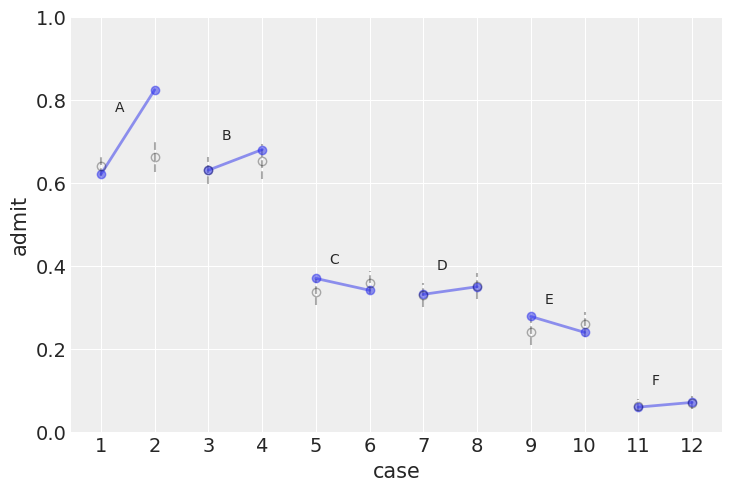

In [26]:
plot_posteriors(df, df_11_8)

In [27]:
df_11_8.filter(items=['a__0', 
                      'a__1', 
                      'delta__0', 
                      'delta__1', 
                      'delta__2', 
                      'delta__3', 
                      'delta__4', 
                      'delta__5']).corr()

,a__0,a__1,delta__0,delta__1,delta__2,delta__3,delta__4,delta__5
a__0,1.000000,0.988670,-0.992126,-0.987666,-0.986981,-0.988056,-0.979661,-0.959878
a__1,0.988670,1.000000,-0.983204,-0.976925,-0.990725,-0.987762,-0.983365,-0.959424
delta__0,-0.992126,-0.983204,1.000000,0.980353,0.980801,0.981251,0.973300,0.952970
delta__1,-0.987666,-0.976925,0.980353,1.000000,0.974667,0.975956,0.967961,0.948308
delta__2,-0.986981,-0.990725,0.980801,0.974667,1.000000,0.982514,0.976524,0.954133
delta__3,-0.988056,-0.987762,0.981251,0.975956,0.982514,1.000000,0.975385,0.953436
delta__4,-0.979661,-0.983365,0.973300,0.967961,0.976524,0.975385,1.000000,0.947525
delta__5,-0.959878,-0.959424,0.952970,0.948308,0.954133,0.953436,0.947525,1.000000
